In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**Making sure the notebook is properly set up and enough gpu ram is availaible**

In [0]:

import numpy as np

import pandas as pd
#import matlpotlib as plt
import os
import math
import datetime
import fastai
from fastai import *
#from fastai.metrics import error_rate
from fastai.vision import *

**In order to upload data to collab notebook or to export trained model to drive we need to link drive with the notebook.**

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
root_dir = "/content/drive/My Drive/"
base_dir = root_dir

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls


drive  sample_data


In [0]:
!ls drive

'My Drive'


train


In [0]:

!unzip -q "/content/drive/My Drive/743_final_pk"

In [0]:
path= "/content/743_final_pk"
!ls "/content/743_final_pk"

train


In [0]:
tfms=get_transforms(do_flip=False)

**Loading the data**

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:457: UserWarning: Your validation set is empty. If this is by design, use `split_none()`
                 or pass `ignore_empty=True` when labelling to remove this warning.
  or pass `ignore_empty=True` when labelling to remove this warning.""")


In [0]:
data = (ImageList.from_folder(path) #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct(0.05)              #How to split in train/valid? -> use the folders
        .label_from_folder()            #How to label? -> depending on the folder of the filenames
        .add_test_folder()              #Optionally add a test set (here default name is test)
        .transform(size=(240,240))       #Data augmentation? -> use tfms with a size of 64
        .databunch())             

In [0]:
data.classes

['a', 'b', 'c', 'd', 'e']

In [0]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['a', 'b', 'c', 'd', 'e'], 5, 27093, 1425)

**Lets have a look at our data**

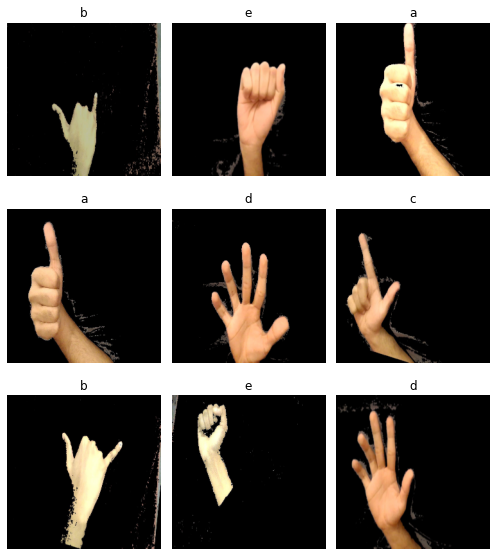

In [0]:
data.show_batch(rows=3, figsize=(7,8))

In [0]:
learn = cnn_learner(data, models.resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
learn.summary

<bound method model_summary of Learner(data=ImageDataBunch;

Train: LabelList (27093 items)
x: ImageList
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: CategoryList
a,a,a,a,a
Path: /content/743_final_pk;

Valid: LabelList (1425 items)
x: ImageList
Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240),Image (3, 240, 240)
y: CategoryList
a,b,a,b,c
Path: /content/743_final_pk;

Test: LabelList (0 items)
x: ImageList

y: EmptyLabelList

Path: /content/743_final_pk, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), b

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [0]:
learn.fit_one_cycle(2)


epoch,train_loss,valid_loss,error_rate,time
0,0.006783,0.000433,0.000000,16:35
1,0.001592,0.000012,0.000000,16:36


In [0]:
learn.model

In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

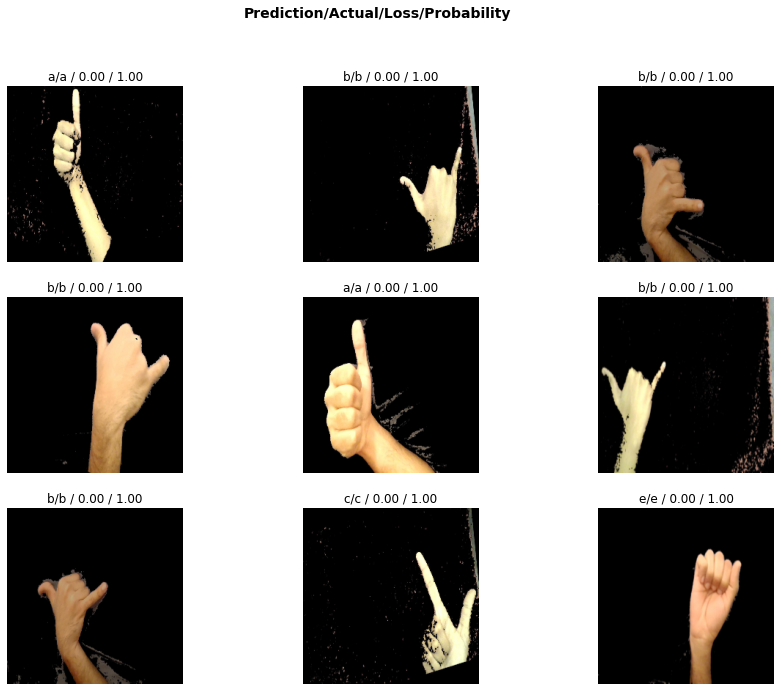

In [0]:
interp.plot_top_losses(9, figsize=(15,11))

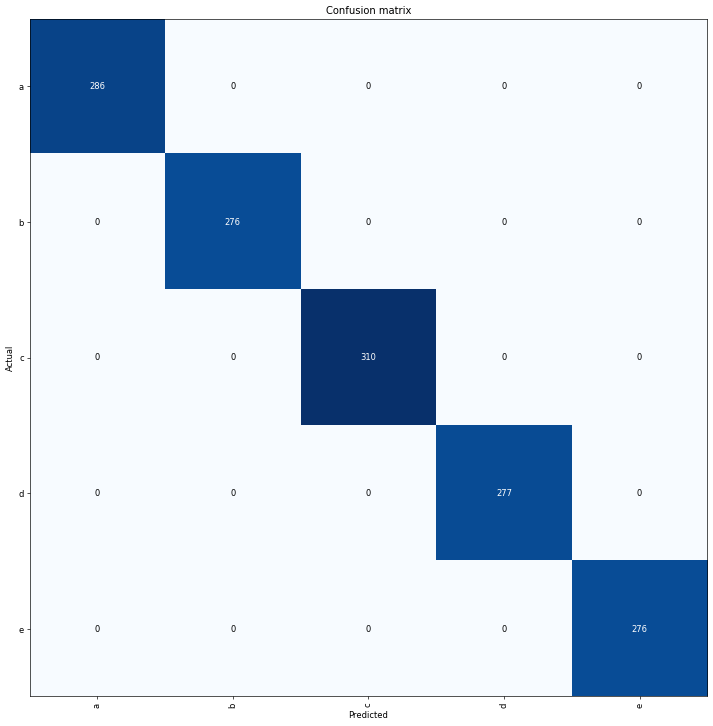

In [0]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

**We can still improve the results by unfreezing the hidden layers, and using improved learning rates**

In [0]:
learn.unfreeze()

In [0]:
learn.lr_find()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


**We use the function lr_find to find ideal learrning rate for our model. The learning ratein summary tells the speed at which I am updating the parameters in my model. The x-axis shows the effect of increasing the learning rate. The y axis represents the loss.In our model we can see that in our model after 5e-3 learning rate the loss skyrockets.  Its interesting why this happens. High learning rate is bad when we are trying to fine tune things. After seeing the plot I pick something way before the loss starts rising. I chose 5e-3 as the learning rate. However middle layers dont need high learning rate so I have chosen 5e-4 as learning rate for them.**



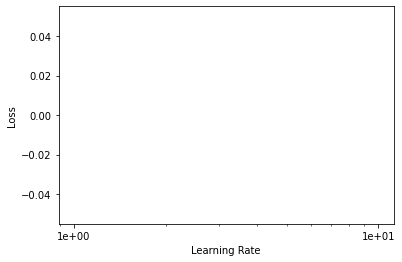

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, max_lr=slice(1e-5,1e-4))


epoch,train_loss,valid_loss,error_rate,time
0,0.013260,0.002749,0.001385,02:09
1,0.005874,0.001898,0.001385,02:08
2,0.005510,0.000514,0.000000,02:09


In [0]:
learn.fit_one_cycle(3, max_lr=slice(1e-4,1e-3))


epoch,train_loss,valid_loss,error_rate,time
1,0.006138,0.023881,0.000000,02:13
2,0.002075,0.003306,0.000000,02:13
3,0.000929,0.003292,0.000000,02:13


In [0]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(data.valid_ds)==len(losses)==len(idxs)

True

**After fine tuning the model we have achieved perfect accuracy.**

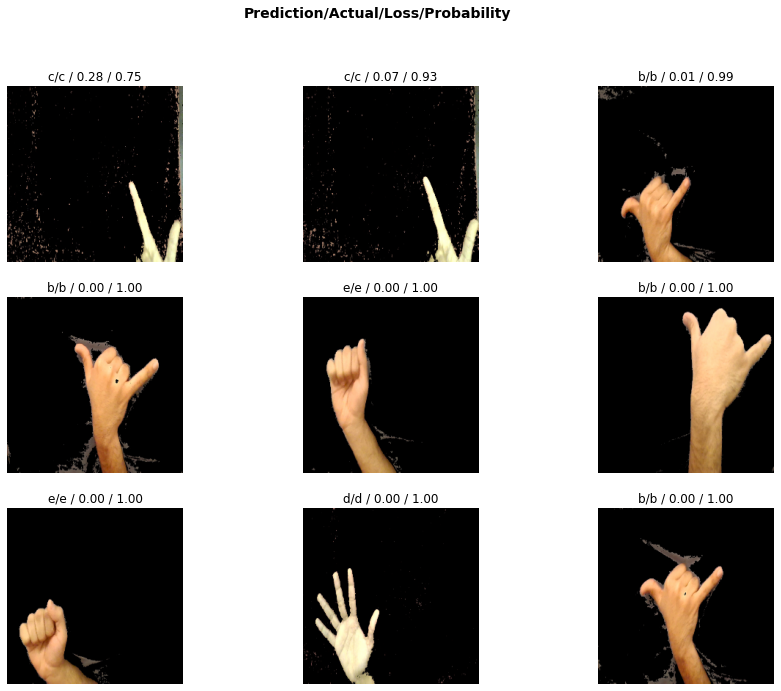

In [0]:
interp.plot_top_losses(9, figsize=(15,11))